# Model 3: Scenario & Robustness Analysis

Building on Model 2's dynamic framework, this 
model introduces "what-if" scenarios to test the strategy's robustness against key uncertainties. 
It evaluates performance against risks like volatile resource prices and increased bidding 
competition. The analysis also incorporates major policy and  environmental variables by 
modelling the financial impact of a new, tech-specific carbon tax. Finally, it simulates weather-
driven revenue fluctuations for renewables by applying variable capacity factors (good vs. bad 
years) to the revenue streams.

##### Notebook Outline
1) Imports
2) Load Input Data
3) Scenario Parameters
4) Gurobi Model Setup
5) Results
6) Visualizations

#### Flow Chart of Optimisation Model

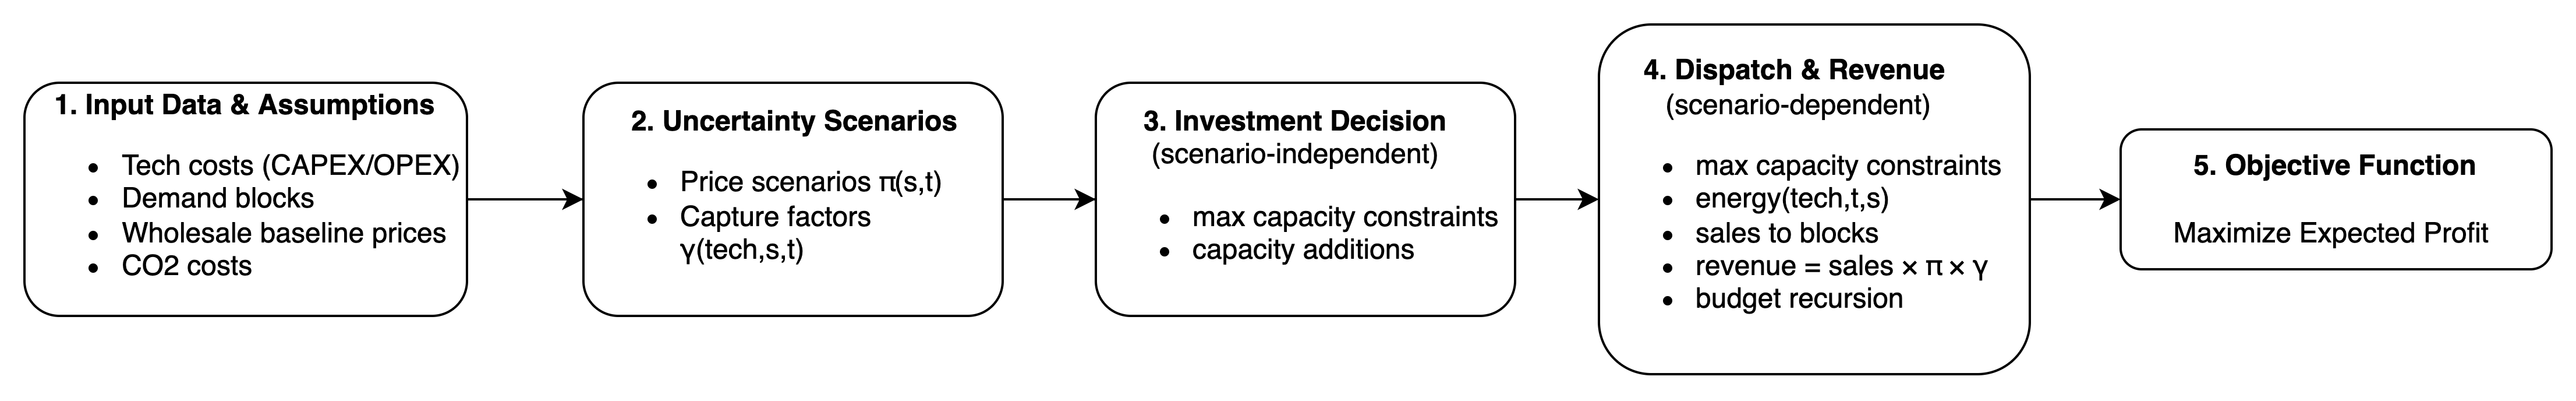
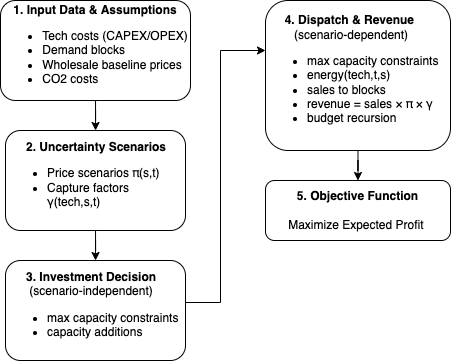

### Imports

In [15]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt

### Load input data

In [ ]:
# technology data
data_path = Path("data") / "technology_data.json"

with data_path.open("r", encoding="utf-8") as f:
    technology_data = json.load(f)

TECHNOLOGY_UNITS = technology_data["TECHNOLOGY_UNITS"]  
TECHNOLOGY_DATA = technology_data["TECHNOLOGY_DATA"]

df_units = pd.DataFrame(list(TECHNOLOGY_UNITS.items()), columns=["Parameter", "Unit"])
df_tech = pd.DataFrame(TECHNOLOGY_DATA).reset_index().rename(columns={"index": "parameter"})
df = df_units.merge(df_tech, left_on="Parameter", right_on="parameter", how="right").drop(columns=["parameter"])
print("Technology Data:")
display(df)

# load electricity prices
price_data_path = Path("data") / "electricity_prices.xlsx"
df_prices = pd.read_excel(price_data_path)[["Year", "Price"]].iloc[:20]
df_prices["Year"] = df_prices["Year"].astype(int)
df_prices["Price"] = df_prices["Price"].astype(float)

exchange_rate = 7.4 # DKK to EUR
df_prices["Price"] = df_prices["Price"]/exchange_rate
price_list = df_prices["Price"].tolist()

df_display = df_prices.T
df_display.columns = df_prices["Year"].tolist()
df_display = df_display.drop("Year")
print("Electricity Prices (EUR/MWh):")
display(df_display)

# load co2 intensity for technologies
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "CO2 intensity": 0
}
costs = costs.value.unstack().fillna(defaults)

co2_intensity = {
    "Diesel engine farm":         costs.at["gas", "CO2 intensity"]*1.2,
    "OCGT - Natural gas":         costs.at["gas", "CO2 intensity"],
    "Coal power plant":           costs.at["coal", "CO2 intensity"],
    "Nuclear power plant":        costs.at["nuclear", "CO2 intensity"],
    "Onshore wind":               costs.at["onwind", "CO2 intensity"],
    "Offshore wind (fixed)":      costs.at["offwind", "CO2 intensity"],
    "Utility-scale PV":           costs.at["solar-utility", "CO2 intensity"],
}

df_co2 = pd.DataFrame.from_dict(co2_intensity, orient="index", columns=["CO2 intensity (tCO2/MWh)"]).T
print("CO2 Intensity by Technology:")
display(df_co2)

net_capacity = pd.read_csv(Path("data") / "net_installed_capacity.csv")
# Drop the first (metadata) row, reset index, convert capacity columns to numeric and compute total (MW)
net_capacity = net_capacity.iloc[1:].reset_index(drop=True)

# Convert all columns except 'Year' to numeric (they are GW in the source)
num_cols = [c for c in net_capacity.columns if c != "Year"]
net_capacity[num_cols] = net_capacity[num_cols].apply(pd.to_numeric, errors="coerce")

# Sum capacities (assume values are in GW) and convert to MW
sum_capacity_gw = net_capacity[num_cols].sum().sum()
sum_capacity = sum_capacity_gw * 1e3  # MW

print("Net installed capacity (cleaned):")
display(net_capacity)
print(f"Total installed capacity in dataset: {sum_capacity:.2f} MW")

Technology Data:


,Parameter,Unit,Diesel engine farm,OCGT - Natural gas,Coal power plant,Nuclear power plant,Onshore wind,Offshore wind (fixed),Utility-scale PV
0,nominal_investment_total,MEUR/MW_el,0.36,0.47,2.10,4.000,1.150,2.390,0.38
1,fixed_om_total,EUR/MW/year,8983.37,8236.12,34324.40,147700.000,16663.000,34000.000,9500.00
2,variable_om_total,EUR/MWh,6.38,4.79,3.21,20.000,0.000,0.000,0.00
3,elec_eff,fraction (0-1),0.35,0.41,0.52,0.360,0.410,0.520,0.16
4,technical_lifetime,years,25.00,25.00,25.00,60.000,30.000,30.000,35.00
5,construction_time,years,1.00,0.20,4.50,8.000,1.500,3.500,0.50
6,total_outage,fraction of time (0-1),0.01,0.01,0.00,0.001,0.023,0.025,NaN


Electricity Prices (EUR/MWh):


,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044
Price,90.598127,88.152135,83.576931,82.826762,80.538427,79.397276,74.590121,67.366515,64.427126,62.897569,58.468283,59.1168,59.890278,60.807289,61.886407,63.146206,64.605259,66.28214,68.195421,70.363677


CO2 Intensity by Technology:


,Diesel engine farm,OCGT - Natural gas,Coal power plant,Nuclear power plant,Onshore wind,Offshore wind (fixed),Utility-scale PV
CO2 intensity (tCO2/MWh),0.2376,0.198,0.3361,0.0,0.0,0.0,0.0


Net installed capacity (cleaned):


,Year,Hydro Run-of-River,Biomass,Fossil hard coal,Fossil oil,Fossil gas,Other renewables,Waste,Wind offshore,Wind onshore,Solar AC
0,2025.0,0.01,1.75,3.02,0.96,1.57,0.14,0.38,2.65,4.86,3.73


Total installed capacity in dataset: 19070.00 MW


### Scenario Parameters

In [ ]:
market_share = 0.10                               
hours_per_year = 8760

initial_budget = 150                              # MEUR
base_demand = market_share * 35_250_000           # MWh
demand_growth_rate = 0.02                         # yearly growth

carbon_price = 83  # EUR/tCO2, taken from https://tradingeconomics.com/commodity/carbon
carbon_increase = 5  # EUR/tCO2 per year

net_revenue_factor = 0.7 

num_scenarios = 100

# Maximum cumulative installed capacity per tech (MW)
max_capacity = {
    "Diesel engine farm":         market_share*sum_capacity*0.2,
    "OCGT - Natural gas":         market_share*sum_capacity*0.2,
    "Coal power plant":           market_share*sum_capacity*0.2,
    "Nuclear power plant":        market_share*sum_capacity*0.2,
    "Onshore wind":               market_share*sum_capacity*0.2,
    "Offshore wind (fixed)":      market_share*sum_capacity*0.2,
    "Utility-scale PV":           market_share*sum_capacity*0.2,
}

gamma_mean = {
    "Utility-scale PV":        0.85,
    "Onshore wind":            0.90,
    "Offshore wind (fixed)":   0.92,
    "OCGT - Natural gas":      1.05,
    "Diesel engine farm":      1.00,
    "Coal power plant":        1.00,
    "Nuclear power plant":     1.00,
}

# helper variables
baseline_prices = df_prices["Price"].tolist()   # EUR/MWh
num_periods = len(baseline_prices)
time_periods = list(range(num_periods))
scenarios = list(range(num_scenarios))
tech_names = list(TECHNOLOGY_DATA.keys())

### Uncertainty Scenario Generation

In [18]:
def generate_hub_price_scenarios(num_scenarios, baseline_prices):
    """
    Generate stochastic yearly hub price scenarios around a baseline price path.

    baseline_prices: list or array of yearly prices [EUR/MWh]
    returns: dict {scenario: [price_t for t in T]} in EUR/MWh
    """
    T = len(baseline_prices)
    scenarios = {}

    for s in range(num_scenarios):
        shock = 0.0
        price_path = []

        for t in range(T):
            eps = np.random.normal(0, 0.15)   # 15% price volatility
            shock = 0.7 * shock + eps         # AR(1) persistence
            price = baseline_prices[t] * (1 + shock)

            # allow negative but prevent extreme outliers
            price = max(-20, min(price, 300))

            price_path.append(price)

        scenarios[s] = price_path

    return scenarios

def generate_capture_factor_scenarios(tech_names, gamma_mean, 
                                      num_scenarios, num_periods,
                                      gamma_sigma=0.05, rho_gamma=0.7):
    """
    Generate tech-specific capture factor scenarios.
    
    gamma_mean: dict {tech: mean capture rate}
    returns: dict gamma[(tech, s, t)]
    """
    gamma = {}

    for tech in tech_names:
        for s in range(num_scenarios):
            shock = 0.0
            for t in range(num_periods):
                eps = np.random.normal(0, gamma_sigma)
                shock = rho_gamma * shock + eps

                g = gamma_mean.get(tech, 1.0) * (1 + shock)
                g = max(0.5, min(1.3, g))  # keep realistic bounds

                gamma[(tech, s, t)] = g

    return gamma

In [ ]:
# generate electricity price scenarios
hub_price_scenarios = generate_hub_price_scenarios(
    num_scenarios=num_scenarios,
    baseline_prices=baseline_prices
)

# check lengths
for s in scenarios:
    assert len(hub_price_scenarios[s]) == num_periods, "All scenarios must have same length"

# generate capture factor scenarios    
gamma = generate_capture_factor_scenarios(
    tech_names=tech_names,
    gamma_mean=gamma_mean,
    num_scenarios=num_scenarios,
    num_periods=num_periods,
    gamma_sigma=0.05,
    rho_gamma=0.7
)

#### Preprocessing - build parameter dictionaries

In [ ]:
#  Technical & economic parameters 
capex = {tech: TECHNOLOGY_DATA[tech]['nominal_investment_total']
         for tech in tech_names}

elec_eff = {tech: TECHNOLOGY_DATA[tech]['elec_eff']
            for tech in tech_names}

vom_eur = {tech: TECHNOLOGY_DATA[tech]['variable_om_total']
           for tech in tech_names}

vom_meur = {tech: vom_eur[tech] / 1e6
            for tech in tech_names}

fixed_om_eur = {tech: TECHNOLOGY_DATA[tech]['fixed_om_total']
                for tech in tech_names}

fixed_om_meur = {tech: fixed_om_eur[tech] / 1e6
                 for tech in tech_names}

#  Demand curve 
demand = {
    t: base_demand * ((1 + demand_growth_rate) ** t)
    for t in time_periods
}

#  Prices 
carbon_price_eur_per_tco2 = {
    t: carbon_price + carbon_increase*t     # EUR/tCO2
    for t in time_periods
}

carbon_price_meur_per_tco2 = {
    t: carbon_price_eur_per_tco2[t] / 1e6   # MEUR/tCO2
    for t in time_periods
}

price_scenarios_meur = {
    s: [p / 1e6 for p in hub_price_scenarios[s]]
    for s in scenarios
}

blocks = [1, 2, 3]

pi_block = {}
for s in scenarios:
    for t in time_periods:
        p = price_scenarios_meur[s][t]
        pi_block[(s, t, 1)] = 1.00 * p
        pi_block[(s, t, 2)] = 0.85 * p
        pi_block[(s, t, 3)] = 0.60 * p

blocks = [1, 2, 3]

#  Block quantity caps (per year, deterministic) 
Q_block = {}
for t in time_periods:
    Q_block[(t, 1)] = 0.25 * demand[t]  # highest-value block
    Q_block[(t, 2)] = 0.35 * demand[t]  # mid block
    Q_block[(t, 3)] = 0.40 * demand[t]  # lowest block

### Gurobi Model Setup

#### Variables

In [ ]:
model = gp.Model("Dynamic_Revenue_Maximization")

# Investment in new capacity [MW] in period t (here-and-now)
investment = model.addVars(
    tech_names, time_periods,
    vtype=GRB.CONTINUOUS,
    name="Investment"
)

# Available capacity [MW] in period t (accumulated, here and now)
capacity = model.addVars(
    tech_names, time_periods,
    vtype=GRB.CONTINUOUS,
    name="Capacity"
)

# Energy produced [MWh] by tech in period t, scenario s
energy = model.addVars(
    tech_names, time_periods, scenarios,
    vtype=GRB.CONTINUOUS,
    name="Energy"
)

# Budget available in each period t, scenario s [MEUR]
budget = model.addVars(
    time_periods, scenarios,
    vtype=GRB.CONTINUOUS,
    name="Budget"
)

# Revenue in each period t, scenario s [MEUR]
revenue = model.addVars(
    time_periods, scenarios,
    vtype=GRB.CONTINUOUS,
    name="Revenue"
)

# Variable O&M cost in each period t, scenario s [MEUR]
op_cost = model.addVars(
    time_periods, scenarios,
    vtype=GRB.CONTINUOUS,
    name="OperatingCost"
)

# Fixed O&M cost in each period t (same across scenarios) [MEUR]
fixed_om_cost = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="FixedOMCost"
)

# CAPEX in each period t (same across scenarios) [MEUR]
capex_cost = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="CapexCost"
)

# CO2 cost in each period t, scenario s [MEUR]
co2_cost = model.addVars(
    time_periods, scenarios,
    vtype=GRB.CONTINUOUS,
    name="CO2Cost"
)

# Energy  sold [MWh] by tech in period t, block b, scenario s
sales = model.addVars(
    tech_names, time_periods, blocks, scenarios,
    vtype=GRB.CONTINUOUS,
    name="Sales"
)

#### Model constraints

In [117]:
# capacity accumulation (scenario independent)
for tech in tech_names:
    # Initial capacity is whatever is invested at t=0
    model.addConstr(
        capacity[tech, 0] == investment[tech, 0],
        name=f"CapacityInit_{tech}"
    )
    for t in time_periods[1:]:
        model.addConstr(
            capacity[tech, t] ==
            capacity[tech, t-1] + investment[tech, t],
            name=f"CapacityAccum_{tech}_{t}"
        )

# capacity limits (here-and-now)
for tech in tech_names:
    if tech in max_capacity:
        for t in time_periods:
            model.addConstr(
                capacity[tech, t] <= max_capacity[tech],
                name=f"MaxCap_{tech}_{t}"
            )

# production limits
# energy <= capacity * efficiency * hours_per_year
for tech in tech_names:
    for t in time_periods:
        for s in scenarios:
            model.addConstr(
                energy[tech, t, s] <=
                capacity[tech, t] * elec_eff[tech] * hours_per_year,
                name=f"ProdCap_{tech}_{t}_s{s}"
            )

# cost definitions
for t in time_periods:

    # CAPEX (scenario independent)
    model.addConstr(
        capex_cost[t] == gp.quicksum(
            investment[tech, t] * capex[tech]
            for tech in tech_names
        ),
        name=f"CapexCostDef_{t}"
    )

    # FIXED O&M (scenario independent)
    model.addConstr(
        fixed_om_cost[t] == gp.quicksum(
            capacity[tech, t] * fixed_om_meur[tech]
            for tech in tech_names
        ),
        name=f"FixedOMDef_{t}"
    )

    for s in scenarios:

        # VARIABLE O&M
        model.addConstr(
            op_cost[t, s] == gp.quicksum(
                energy[tech, t, s] * vom_meur[tech]
                for tech in tech_names
            ),
            name=f"OpCostDef_{t}_s{s}"
        )

        # CO₂ COST
        model.addConstr(
            co2_cost[t, s] == gp.quicksum(
                energy[tech, t, s]
                * co2_intensity[tech]
                * carbon_price_meur_per_tco2[t]
                for tech in tech_names
            ),
            name=f"CO2CostDef_{t}_s{s}"
        )

# energy -> block sales allocation (per tech)
for tech in tech_names:
    for t in time_periods:
        for s in scenarios:
            model.addConstr(
                gp.quicksum(sales[tech, t, b, s] for b in blocks)
                == energy[tech, t, s],
                name=f"SalesAlloc_{tech}_{t}_s{s}"
            )


for t in time_periods:
    # block capacity limits (competition across techs)
    for b in blocks:
        for s in scenarios:
            model.addConstr(
                gp.quicksum(sales[tech, t, b, s] for tech in tech_names)
                <= Q_block[(t, b)],
                name=f"BlockCap_{t}_{b}_s{s}"
            )
        
    # revenue with capture factors       
    for s in scenarios:
        model.addConstr(
            revenue[t, s] == gp.quicksum(
                sales[tech, t, b, s]
                * pi_block[(s, t, b)]
                * gamma[(tech, s, t)]
                * net_revenue_factor
                for tech in tech_names
                for b in blocks
            ),
            name=f"RevenueDef_{t}_s{s}"
        )

# budget constraints (scenario dependent)
for s in scenarios:

    # Initial budget
    model.addConstr(
        budget[0, s] == initial_budget,
        name=f"BudgetInit_s{s}"
    )

    for t in time_periods:

        # Investment cannot exceed budget of scenario s at time t
        model.addConstr(
            capex_cost[t] <= budget[t, s],
            name=f"InvLimit_t{t}_s{s}"
        )

        # Budget cannot go negative
        model.addConstr(
            budget[t, s] >= 0,
            name=f"BudgetNonNeg_t{t}_s{s}"
        )

        # Budget recursion for all except last period
        if t < num_periods - 1:
            model.addConstr(
                budget[t+1, s] ==
                budget[t, s]
                - capex_cost[t]
                + revenue[t, s]
                - op_cost[t, s]
                - fixed_om_cost[t]
                - co2_cost[t, s],
                name=f"BudgetDyn_{t}_s{s}"
            )

#### Objective Function + optimize

In [ ]:
num_scenarios = len(scenarios)

model.setObjective(
    (1 / num_scenarios) * gp.quicksum(
        revenue[t, s]
        - op_cost[t, s]
        - co2_cost[t, s]
        - fixed_om_cost[t]
        - capex_cost[t]
        for s in scenarios
        for t in time_periods
    ),
    GRB.MAXIMIZE
)

model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 25.0.0 25A362)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 46320 rows, 64320 columns and 208273 nonzeros
Model fingerprint: 0x48155138
Coefficient statistics:
  Matrix range     [3e-06, 5e+03]
  Objective range  [1e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+06]
Presolve removed 24576 rows and 21561 columns
Presolve time: 0.09s
Presolved: 21744 rows, 42759 columns, 142400 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 175
 AA' NZ     : 8.174e+04
 Factor NZ  : 3.808e+05 (roughly 30 MB of memory)
 Factor Ops : 1.474e+07 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
 

#### Results

Underlying Uncertainties

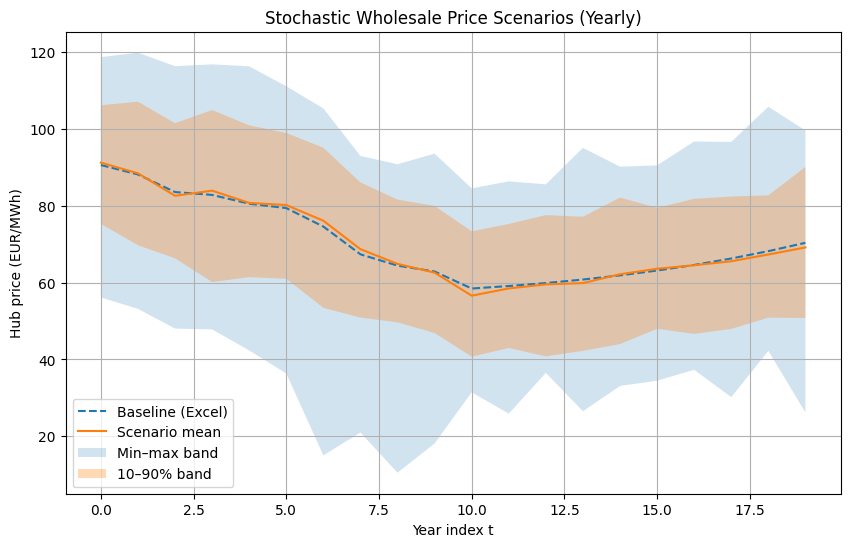

In [118]:
# wholesale prices

# Convert scenario dict to matrix [num_scenarios x num_periods]
price_matrix = np.array([
    hub_price_scenarios[s] for s in scenarios
])  # shape: (S, T)

mean_price = price_matrix.mean(axis=0)
min_price  = price_matrix.min(axis=0)
max_price  = price_matrix.max(axis=0)

# Optional: percentiles for less extreme bands
p10 = np.percentile(price_matrix, 10, axis=0)
p90 = np.percentile(price_matrix, 90, axis=0)

plt.figure(figsize=(10,6))

# Baseline from Excel
plt.plot(time_periods, baseline_prices, linestyle="--", label="Baseline (Excel)")

# Scenario mean
plt.plot(time_periods, mean_price, label="Scenario mean")

# Min–max band
plt.fill_between(time_periods, min_price, max_price, alpha=0.2, label="Min–max band")

# Optional: 10–90% band (less sensitive to outliers)
plt.fill_between(time_periods, p10, p90, alpha=0.3, label="10–90% band")

plt.xlabel("Year index t")
plt.ylabel("Hub price (EUR/MWh)")
plt.title("Stochastic Wholesale Price Scenarios (Yearly)")
plt.grid(True)
plt.legend()
plt.show()

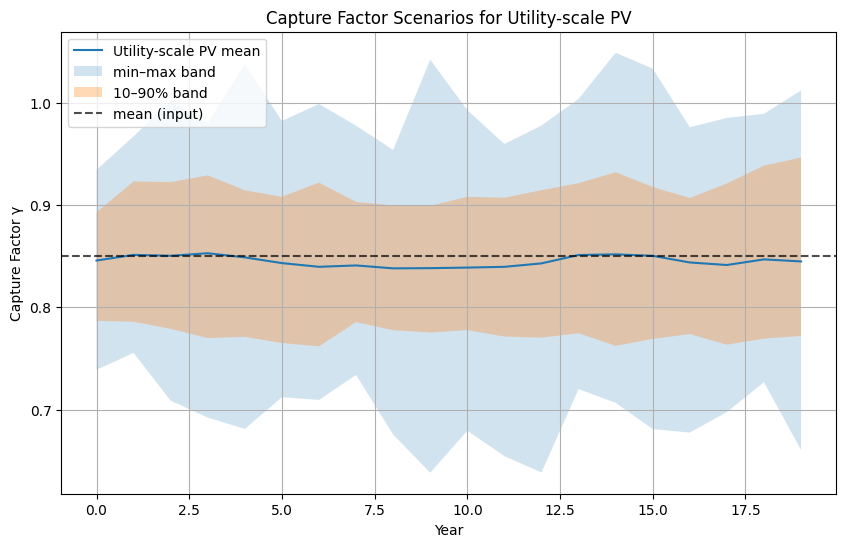

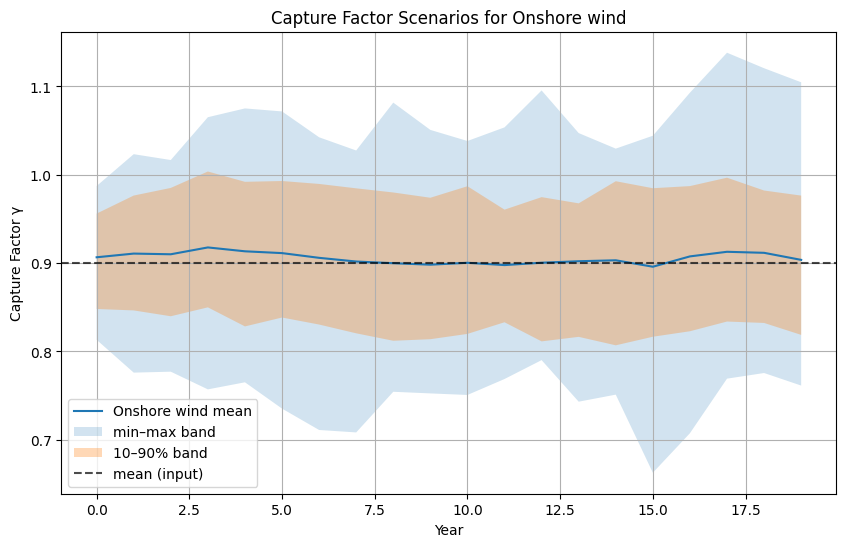

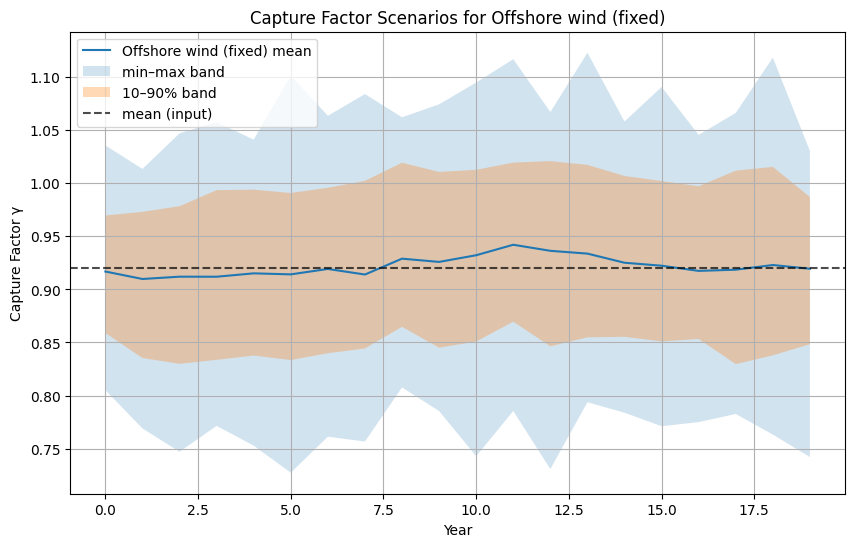

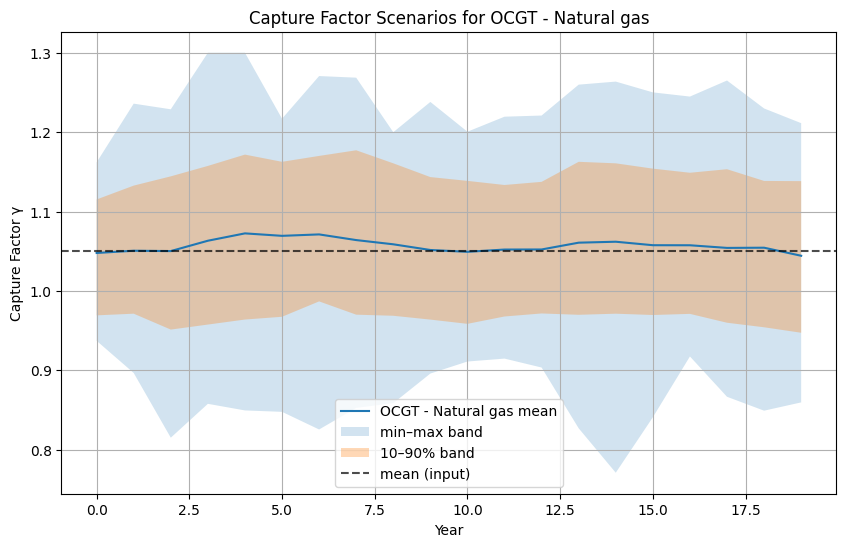

In [119]:
# capture factors

def build_gamma_matrix(tech):
    """
    Returns a matrix of shape [num_scenarios x num_periods]
    for the capture factor of a given technology.
    """
    mat = np.zeros((num_scenarios, num_periods))
    for s in scenarios:
        for t in time_periods:
            mat[s, t] = gamma[(tech, s, t)]
    return mat

def plot_gamma_for_tech(tech):
    gamma_mat = build_gamma_matrix(tech)

    mean_g = gamma_mat.mean(axis=0)
    p10    = np.percentile(gamma_mat, 10, axis=0)
    p90    = np.percentile(gamma_mat, 90, axis=0)
    min_g  = gamma_mat.min(axis=0)
    max_g  = gamma_mat.max(axis=0)

    plt.figure(figsize=(10,6))

    # Mean
    plt.plot(time_periods, mean_g, label=f"{tech} mean")

    # Min–max shading
    plt.fill_between(time_periods, min_g, max_g, alpha=0.2, label="min–max band")

    # 10–90% band
    plt.fill_between(time_periods, p10, p90, alpha=0.30, label="10–90% band")

    # Horizontal line at mean capture rate
    plt.axhline(gamma_mean.get(tech, 1.0), color='black', linestyle='--', alpha=0.7, label="mean (input)")

    plt.title(f"Capture Factor Scenarios for {tech}")
    plt.xlabel("Year")
    plt.ylabel("Capture Factor γ")
    plt.grid(True)
    plt.legend()
    plt.show()

for tech in ["Utility-scale PV", "Onshore wind", "Offshore wind (fixed)", "OCGT - Natural gas"]:
    plot_gamma_for_tech(tech)

Model Behavior Validation

In [107]:
scenario_profits = {}

for s in scenarios:
    total_profit = sum(
        revenue[t, s].X
        - op_cost[t, s].X
        - co2_cost[t, s].X
        - fixed_om_cost[t].X
        - capex_cost[t].X
        for t in time_periods
    )
    scenario_profits[s] = total_profit

df_profit = pd.DataFrame.from_dict(scenario_profits, orient='index', columns=['Profit'])
df_profit.head()


,Profit
0,535.541447
1,412.901934
2,298.910175
3,523.090435
4,258.550252


#### Core Performance Table 

In [108]:
expected_profit = df_profit.Profit.mean()
worst_profit = df_profit.Profit.min()
best_profit = df_profit.Profit.max()
profit_volatility = df_profit.Profit.std()
loss_probability = (df_profit.Profit < 0).mean() * 100
CVaR_10 = df_profit.Profit.nsmallest(int(0.1 * len(df_profit))).mean()  # Avg of worst 10%

print(f"Expected Profit: {expected_profit:.2f} MEUR")
print(f"Worst-Case Profit: {worst_profit:.2f} MEUR")
print(f"Best-Case Profit: {best_profit:.2f} MEUR")
print(f"Volatility (Std Dev): {profit_volatility:.2f} MEUR")
print(f"Probability of Loss: {loss_probability:.1f}%")
print(f"CVaR (10% worst): {CVaR_10:.2f} MEUR")


Expected Profit: 374.86 MEUR
Worst-Case Profit: 5.03 MEUR
Best-Case Profit: 627.86 MEUR
Volatility (Std Dev): 121.07 MEUR
Probability of Loss: 0.0%
CVaR (10% worst): 157.31 MEUR


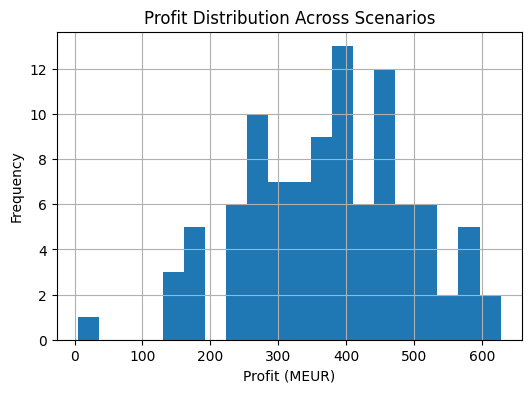

In [109]:
df_profit.Profit.plot(kind='hist', bins=20, figsize=(6,4), title="Profit Distribution Across Scenarios")
plt.xlabel("Profit (MEUR)")
plt.grid(True)
plt.show()


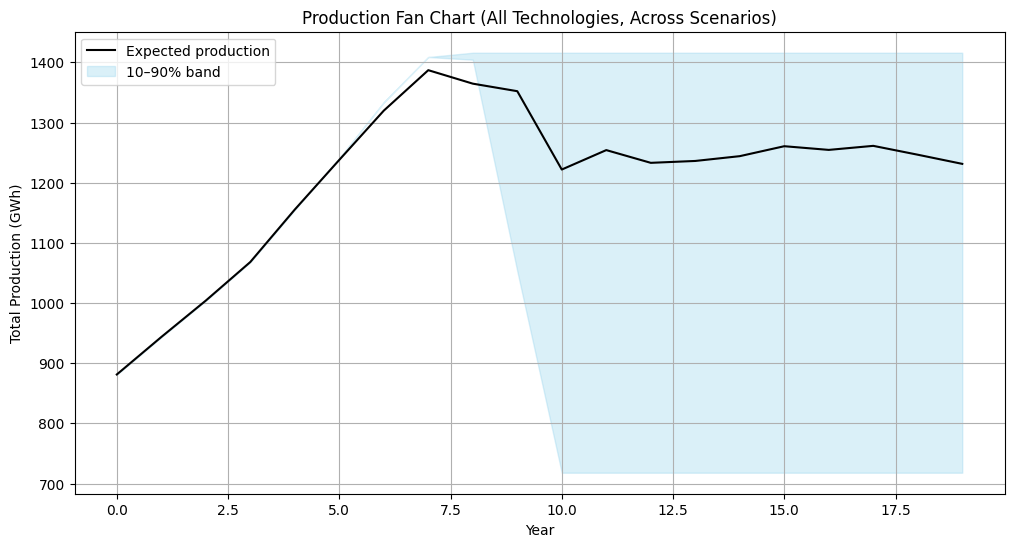

In [110]:
import numpy as np
import matplotlib.pyplot as plt

# Matrix: scenarios x years of total production
prod_total = np.array([
    [sum(energy[tech, t, s].X for tech in tech_names) for t in time_periods]
    for s in scenarios
])

mean_prod = prod_total.mean(axis=0)
p10 = np.percentile(prod_total, 10, axis=0)
p90 = np.percentile(prod_total, 90, axis=0)

plt.figure(figsize=(12,6))
plt.plot(time_periods, mean_prod/1e3, label="Expected production", color="black")

plt.fill_between(time_periods, p10/1e3, p90/1e3,
                 alpha=0.3, color="skyblue", label="10–90% band")

plt.title("Production Fan Chart (All Technologies, Across Scenarios)")
plt.xlabel("Year")
plt.ylabel("Total Production (GWh)")
plt.grid(True)
plt.legend()
plt.show()

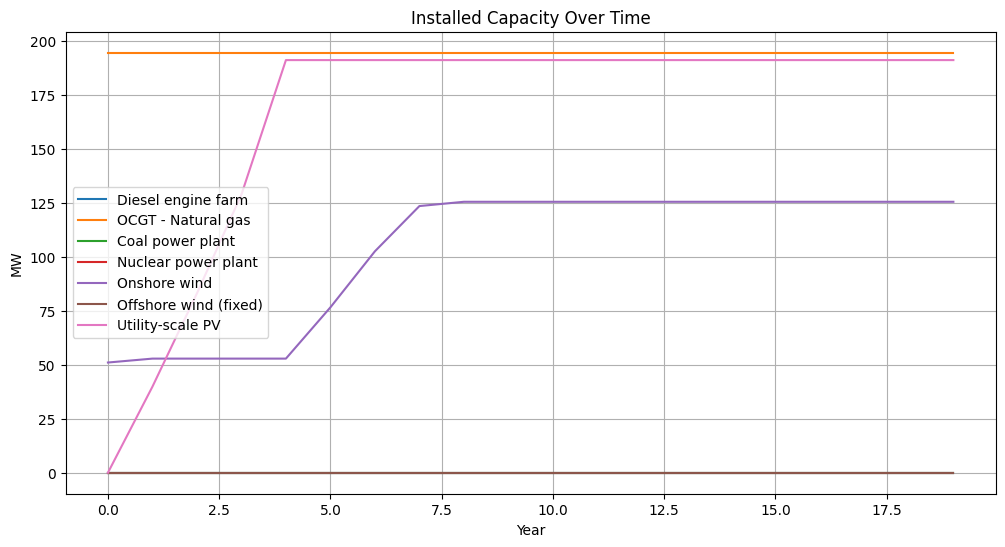

In [111]:
plt.figure(figsize=(12,6))
for tech in tech_names:
    plt.plot(time_periods, [capacity[tech,t].X for t in time_periods], label=tech)
plt.title("Installed Capacity Over Time")
plt.xlabel("Year")
plt.ylabel("MW")
plt.grid(True)
plt.legend()
plt.show()

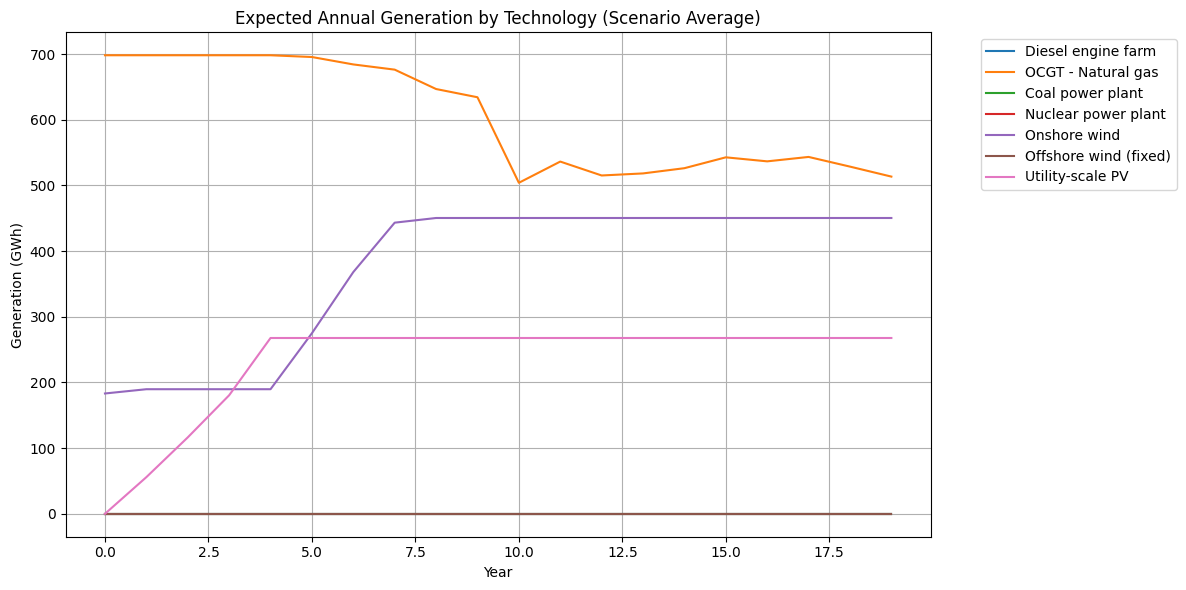

In [112]:
plt.figure(figsize=(12,6))

for tech in tech_names:
    prod_mean = [
        np.mean([energy[tech, t, s].X for s in scenarios])
        for t in time_periods
    ]
    plt.plot(time_periods, np.array(prod_mean)/1e3, label=tech)

plt.title("Expected Annual Generation by Technology (Scenario Average)")
plt.xlabel("Year")
plt.ylabel("Generation (GWh)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

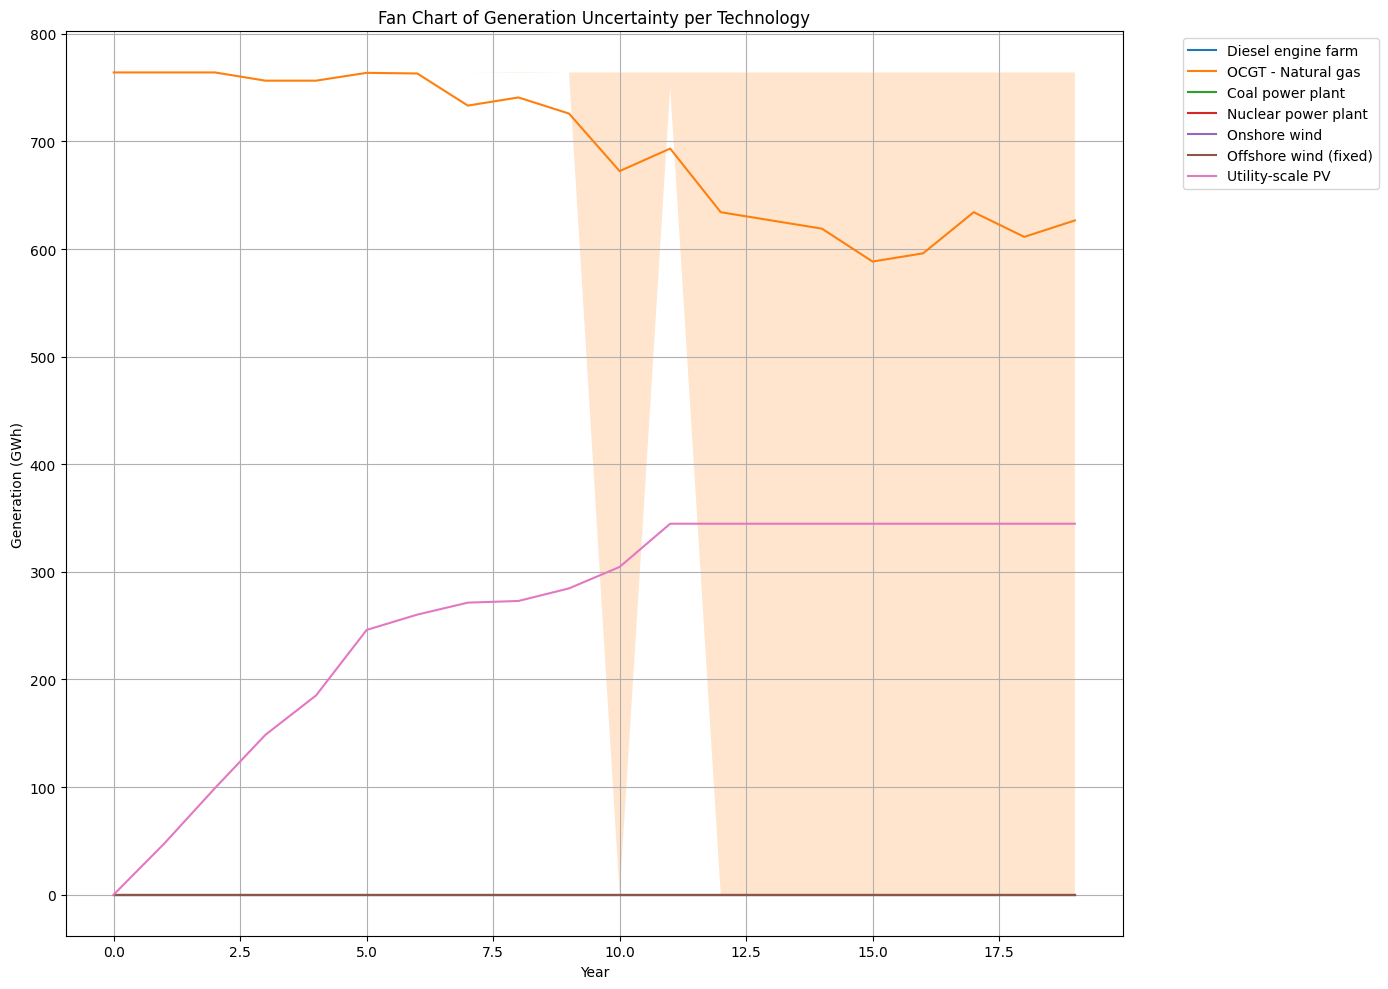

In [99]:
plt.figure(figsize=(14, 10))

for tech in tech_names:
    # Matrix: scenarios × time
    mat = np.array([[energy[tech, t, s].X for t in time_periods]
                    for s in scenarios])
    
    mean_t = mat.mean(axis=0)
    p10_t = np.percentile(mat, 10, axis=0)
    p90_t = np.percentile(mat, 90, axis=0)

    plt.fill_between(time_periods, p10_t/1e3, p90_t/1e3, alpha=0.2)
    plt.plot(time_periods, mean_t/1e3, label=tech)

plt.title("Fan Chart of Generation Uncertainty per Technology")
plt.xlabel("Year")
plt.ylabel("Generation (GWh)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

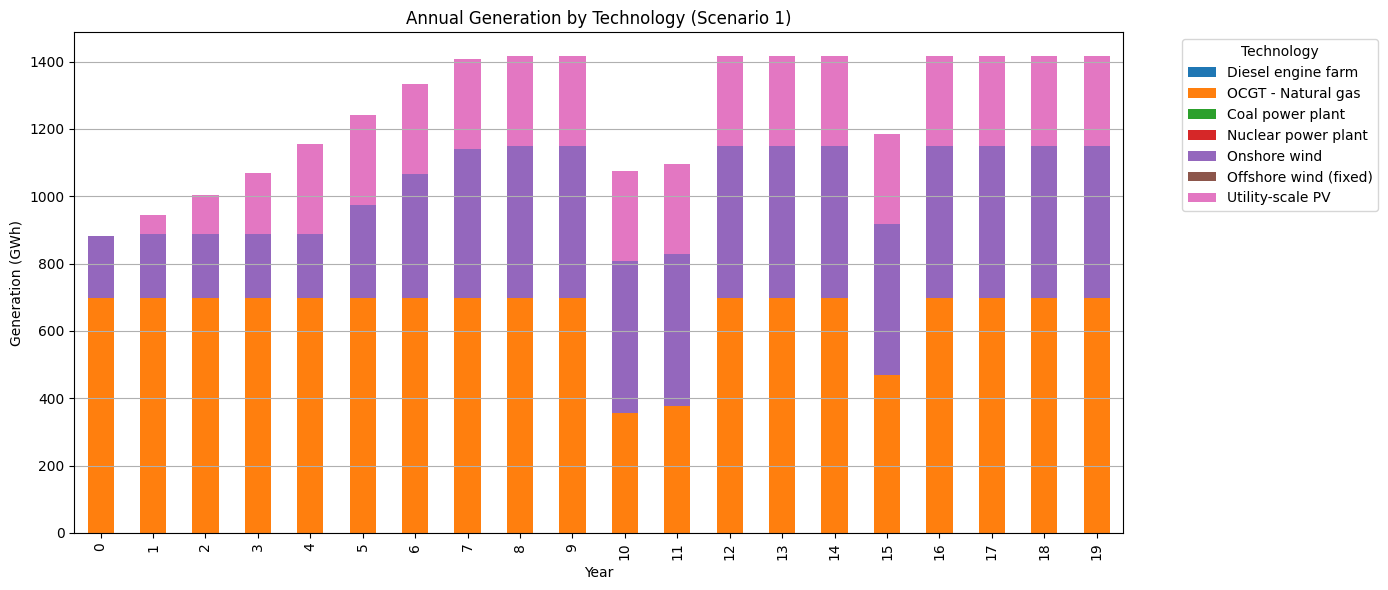

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

# Choose scenario
s = 1

# Build a DataFrame: rows = years, columns = technologies
prod_df = pd.DataFrame({
    tech: [energy[tech, t, s].X for t in time_periods]
    for tech in tech_names
}, index=time_periods)

# Convert MWh → GWh for readability (optional)
prod_df_gwh = prod_df / 1e3

plt.figure(figsize=(14, 7))
prod_df_gwh.plot(kind="bar", stacked=True, figsize=(14,6))

plt.title(f"Annual Generation by Technology (Scenario {s})")
plt.xlabel("Year")
plt.ylabel("Generation (GWh)")
plt.grid(True, axis='y')
plt.legend(title="Technology", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

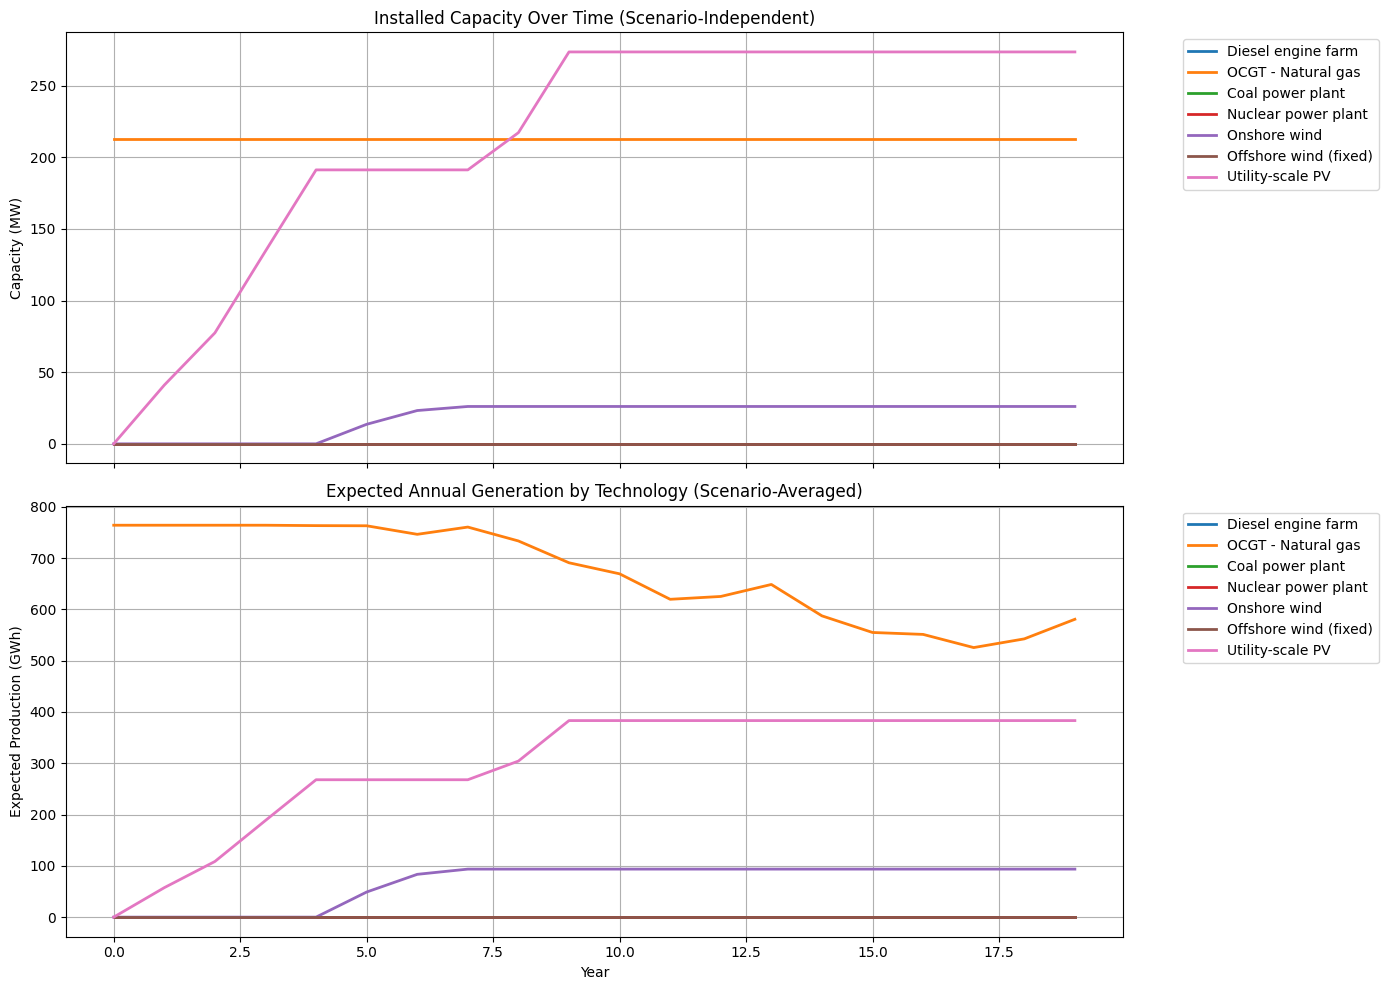

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare expected production per tech
expected_prod = {
    tech: [
        np.mean([energy[tech, t, s].X for s in scenarios])
        for t in time_periods
    ]
    for tech in tech_names
}

# Prepare capacity per tech
capacity_vals = {
    tech: [capacity[tech, t].X for t in time_periods]
    for tech in tech_names
}

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# ---------------------------------------------------------
# 1) Top subplot — Installed Capacity over time
# ---------------------------------------------------------
ax = axes[0]

for tech in tech_names:
    ax.plot(time_periods, capacity_vals[tech],
            label=tech, linewidth=2)

ax.set_ylabel("Capacity (MW)")
ax.set_title("Installed Capacity Over Time (Scenario-Independent)")
ax.grid(True)
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")

# ---------------------------------------------------------
# 2) Bottom subplot — Expected Production over time
# ---------------------------------------------------------
ax = axes[1]

for tech in tech_names:
    ax.plot(time_periods, np.array(expected_prod[tech]) / 1e3,
            label=tech, linewidth=2)

ax.set_xlabel("Year")
ax.set_ylabel("Expected Production (GWh)")
ax.set_title("Expected Annual Generation by Technology (Scenario-Averaged)")
ax.grid(True)
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")

# Layout
plt.tight_layout()
plt.show()

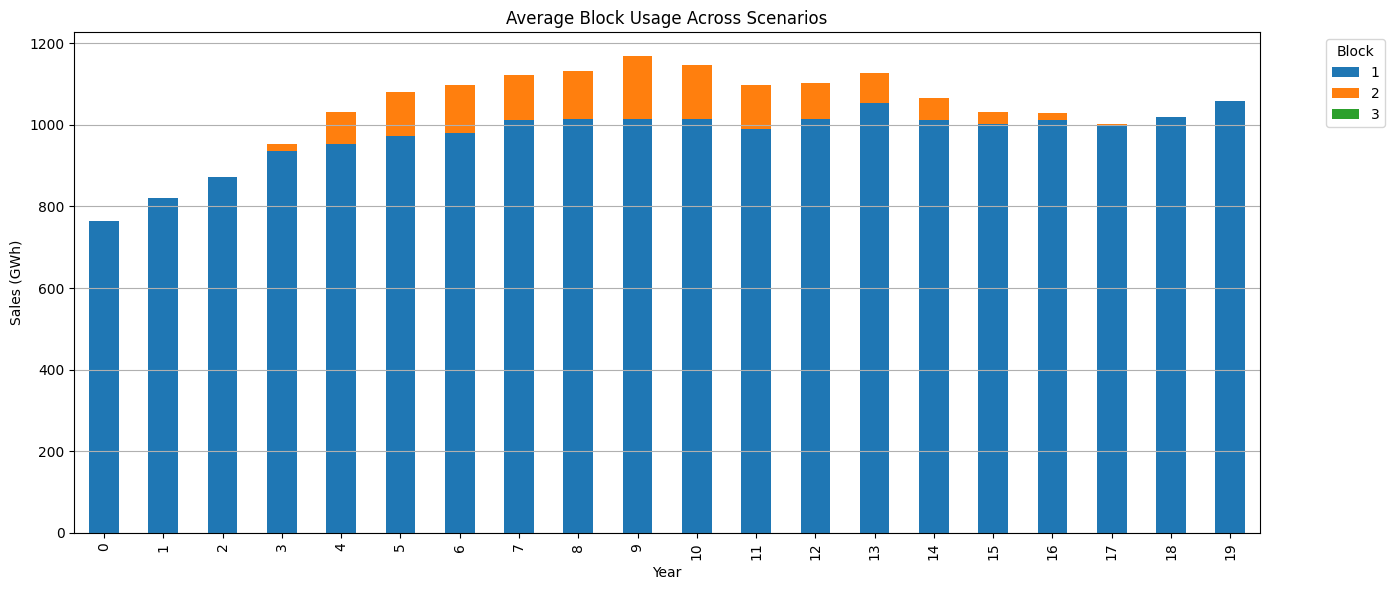

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute average block sales over all scenarios
block_avg = {
    b: [
        np.mean([sum(sales[tech, t, b, s].X for tech in tech_names) for s in scenarios])
        for t in time_periods
    ]
    for b in blocks
}

block_df = pd.DataFrame(block_avg, index=time_periods) / 1e3  # GWh

block_df.plot(kind="bar", stacked=True, figsize=(14,6))
plt.title("Average Block Usage Across Scenarios")
plt.xlabel("Year")
plt.ylabel("Sales (GWh)")
plt.legend(title="Block", bbox_to_anchor=(1.05,1), loc="upper left")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [67]:
import pandas as pd

records = []

for tech in tech_names:
    for s in scenarios:
        for t in time_periods:
            for b in blocks:
                price_eff = (
                    pi_block[(s,t,b)] 
                    * gamma[(tech, s, t)]
                    * net_revenue_factor
                ) * 1e6  # convert MEUR/MWh → EUR/MWh

                records.append({
                    "Technology": tech,
                    "Scenario": s,
                    "Year": t,
                    "Block": b,
                    "EffPrice_EUR_MWh": price_eff
                })

df_eff = pd.DataFrame(records)
df_eff.head()

,Technology,Scenario,Year,Block,EffPrice_EUR_MWh
0,Diesel engine farm,0,0,1,51.486604
1,Diesel engine farm,0,0,2,43.763614
2,Diesel engine farm,0,0,3,30.891963
3,Diesel engine farm,0,1,1,46.128405
4,Diesel engine farm,0,1,2,39.209144


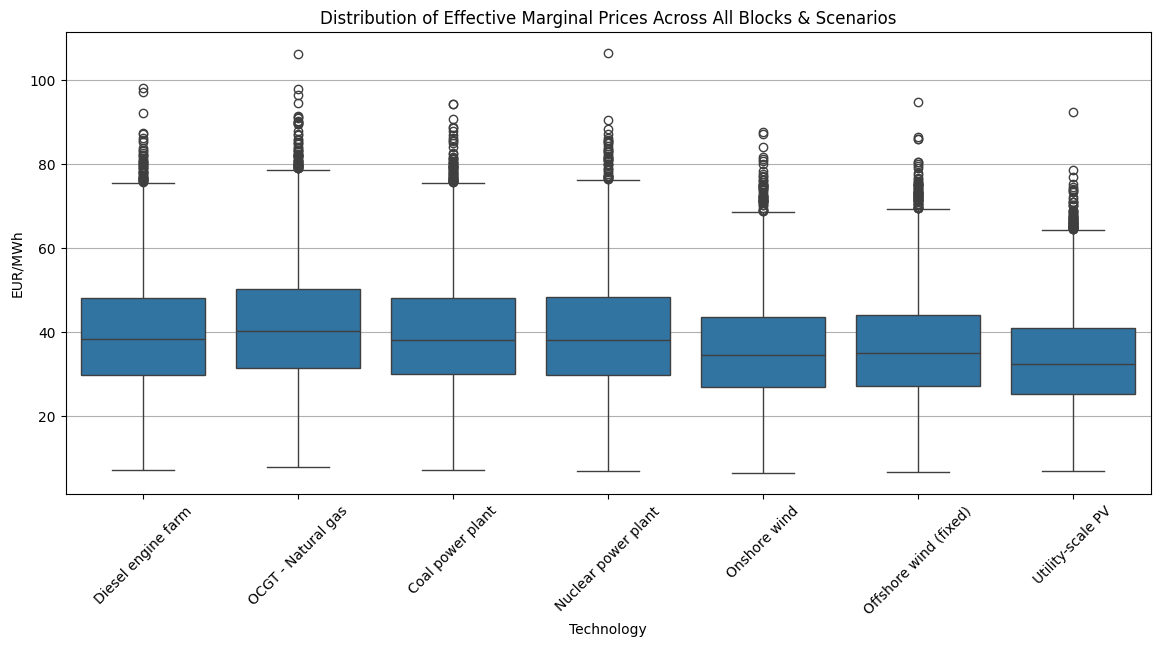

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
sns.boxplot(data=df_eff, x="Technology", y="EffPrice_EUR_MWh")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.title("Distribution of Effective Marginal Prices Across All Blocks & Scenarios")
plt.ylabel("EUR/MWh")
plt.show()

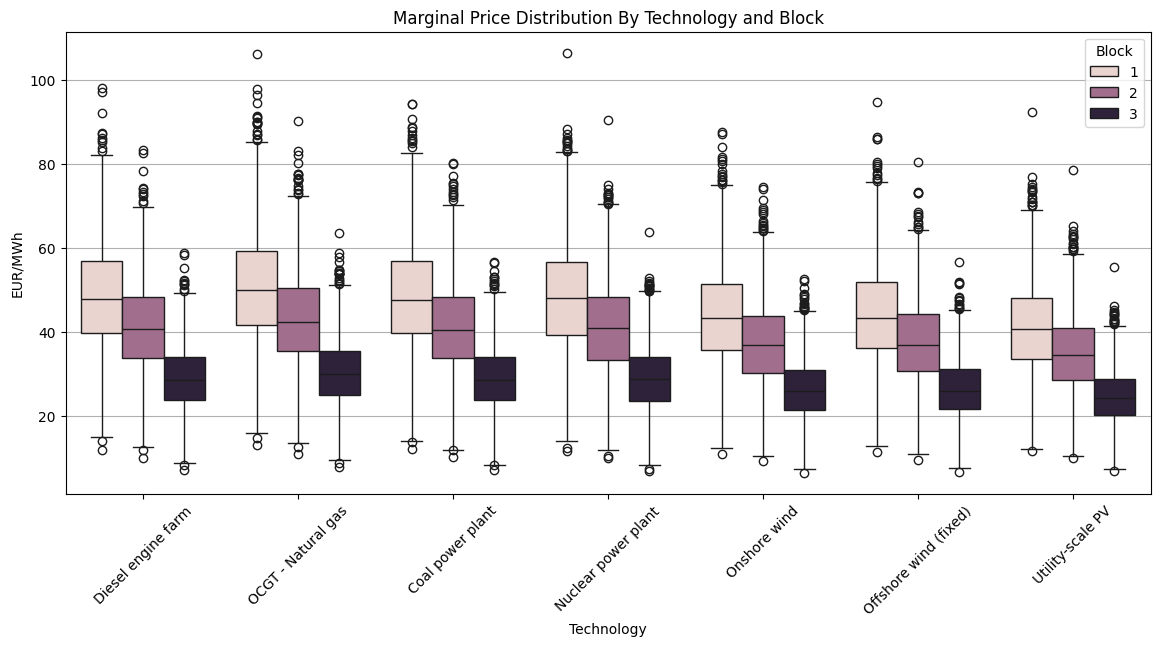

In [70]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df_eff, x="Technology", y="EffPrice_EUR_MWh", hue="Block")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.title("Marginal Price Distribution By Technology and Block")
plt.ylabel("EUR/MWh")
plt.legend(title="Block")
plt.show()

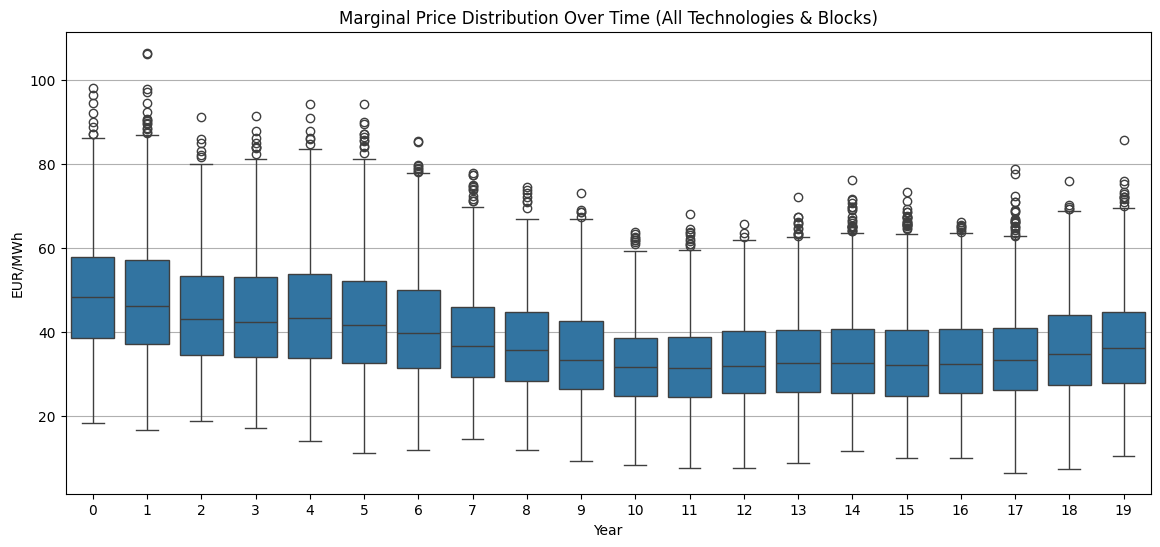

In [71]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df_eff, x="Year", y="EffPrice_EUR_MWh")
plt.grid(axis='y')
plt.title("Marginal Price Distribution Over Time (All Technologies & Blocks)")
plt.ylabel("EUR/MWh")
plt.show()

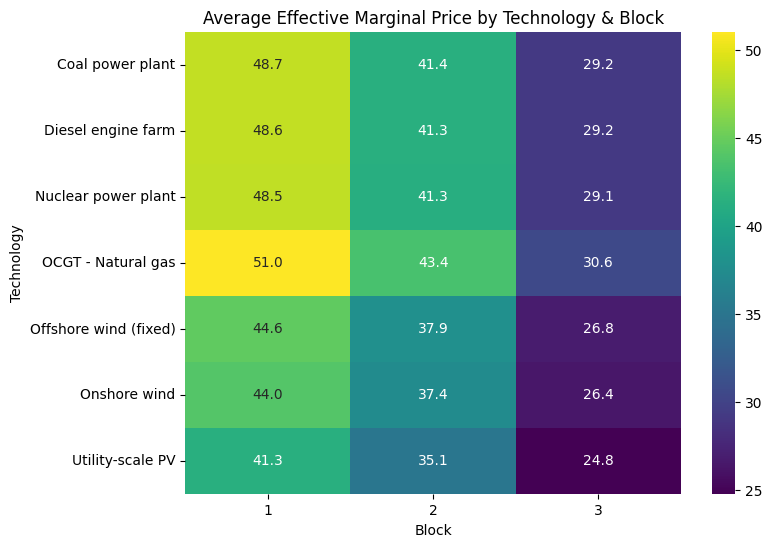

In [72]:
pivot = df_eff.groupby(["Technology","Block"])["EffPrice_EUR_MWh"].mean().unstack()

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="viridis")
plt.title("Average Effective Marginal Price by Technology & Block")
plt.ylabel("Technology")
plt.xlabel("Block")
plt.show()

In [115]:
s = 1
for t in time_periods:
    prod = sum(energy[tech, t, s].X for tech in tech_names)
    sold = sum(sales[tech, t, b, s].X for tech in tech_names for b in blocks)
    print(t, "Prod:", prod, " Sold:", sold)

0 Prod: 881250.0  Sold: 881250.0
1 Prod: 943543.2691631636  Sold: 943543.2691631636
2 Prod: 1004066.8933750415  Sold: 1004066.8933750415
3 Prod: 1068192.5693209686  Sold: 1068192.5693209684
4 Prod: 1155389.6302258917  Sold: 1155389.6302258917
5 Prod: 1240612.611917049  Sold: 1240612.611917049
6 Prod: 1333748.2671326876  Sold: 1333748.2671326876
7 Prod: 1408943.6936561512  Sold: 1408943.6936561512
8 Prod: 1416057.291428582  Sold: 1416057.291428582
9 Prod: 1416057.291428582  Sold: 1416057.2914285823
10 Prod: 1074238.83262038  Sold: 1074238.83262038
11 Prod: 1095723.6092727876  Sold: 1095723.6092727876
12 Prod: 1416057.291428582  Sold: 1416057.2914285823
13 Prod: 1416057.291428582  Sold: 1416057.291428582
14 Prod: 1416057.291428582  Sold: 1416057.291428582
15 Prod: 1186046.4731481394  Sold: 1186046.4731481394
16 Prod: 1416057.291428582  Sold: 1416057.291428582
17 Prod: 1416057.291428582  Sold: 1416057.291428582
18 Prod: 1416057.291428582  Sold: 1416057.2914285823
19 Prod: 1416057.29142858

In [116]:
tech = "OCGT - Natural gas"
for t in time_periods:
    for b in blocks:
        s = 1  # pick a scenario
        unit_rev = pi_block[(s,t,b)] * gamma[(tech,s,t)] * net_revenue_factor
        unit_cost = vom_meur[tech] + co2_intensity[tech] * carbon_price_meur_per_tco2[t]
        print(f"t={t}, b={b}, margin={ (unit_rev - unit_cost)*1e6 :.2f} EUR/MWh")

t=0, b=1, margin=69.51 EUR/MWh
t=0, b=2, margin=55.90 EUR/MWh
t=0, b=3, margin=33.22 EUR/MWh
t=1, b=1, margin=64.97 EUR/MWh
t=1, b=2, margin=51.89 EUR/MWh
t=1, b=3, margin=30.10 EUR/MWh
t=2, b=1, margin=50.36 EUR/MWh
t=2, b=2, margin=39.33 EUR/MWh
t=2, b=3, margin=20.94 EUR/MWh
t=3, b=1, margin=52.32 EUR/MWh
t=3, b=2, margin=40.84 EUR/MWh
t=3, b=3, margin=21.72 EUR/MWh
t=4, b=1, margin=54.55 EUR/MWh
t=4, b=2, margin=42.59 EUR/MWh
t=4, b=3, margin=22.66 EUR/MWh
t=5, b=1, margin=33.74 EUR/MWh
t=5, b=2, margin=24.75 EUR/MWh
t=5, b=3, margin=9.77 EUR/MWh
t=6, b=1, margin=22.49 EUR/MWh
t=6, b=2, margin=15.04 EUR/MWh
t=6, b=3, margin=2.63 EUR/MWh
t=7, b=1, margin=12.56 EUR/MWh
t=7, b=2, margin=6.45 EUR/MWh
t=7, b=3, margin=-3.73 EUR/MWh
t=8, b=1, margin=21.20 EUR/MWh
t=8, b=2, margin=13.65 EUR/MWh
t=8, b=3, margin=1.06 EUR/MWh
t=9, b=1, margin=19.48 EUR/MWh
t=9, b=2, margin=12.04 EUR/MWh
t=9, b=3, margin=-0.37 EUR/MWh
t=10, b=1, margin=4.77 EUR/MWh
t=10, b=2, margin=-0.62 EUR/MWh
t=10, b=3, 

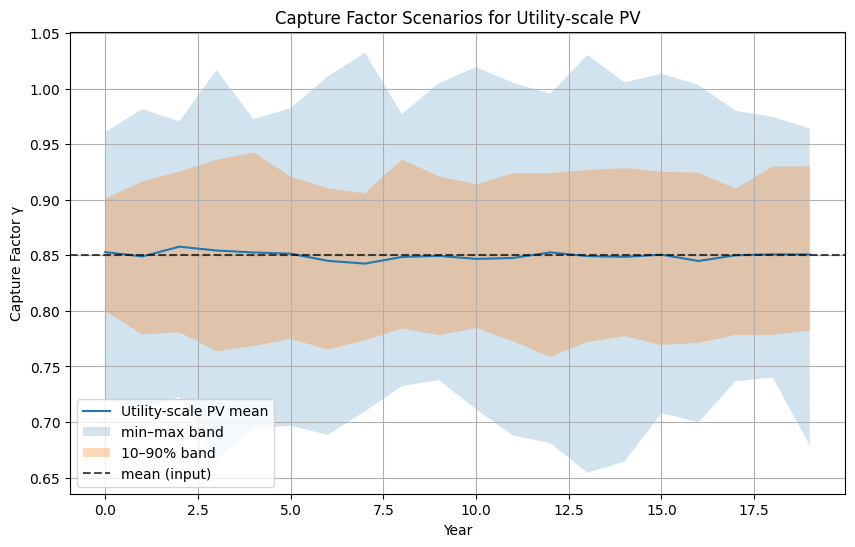

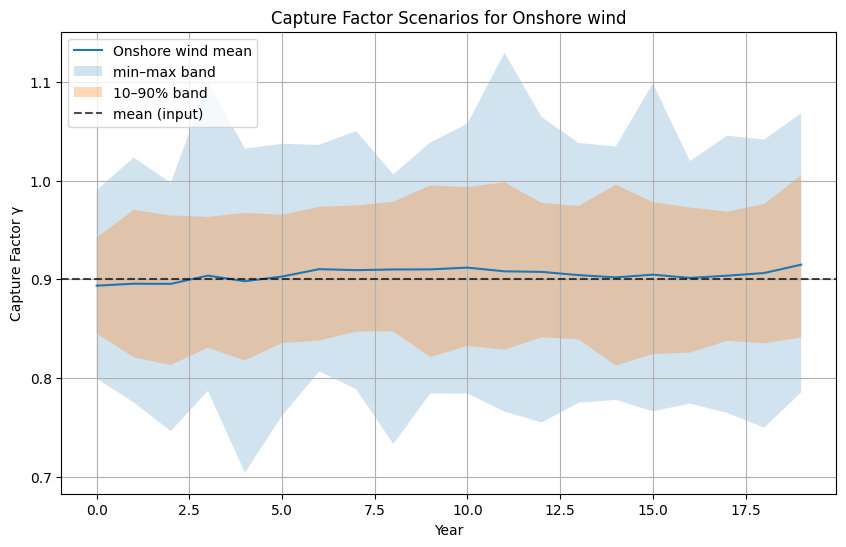

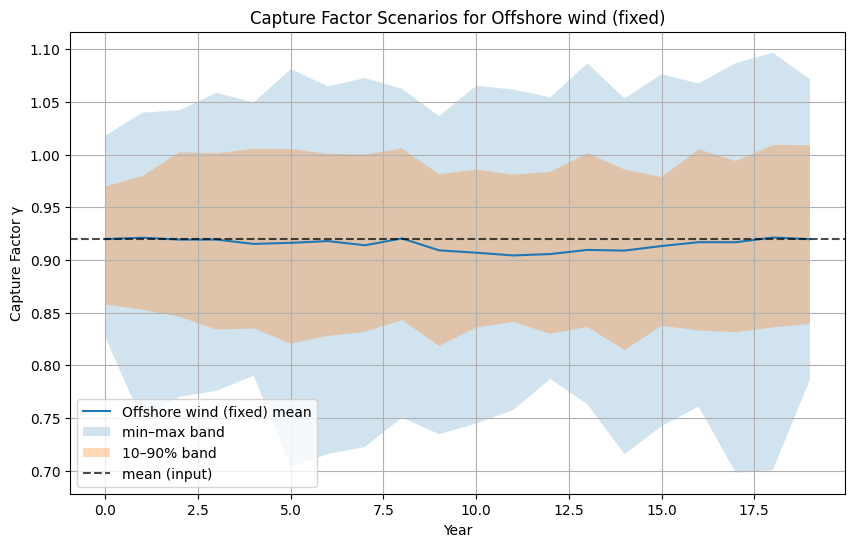

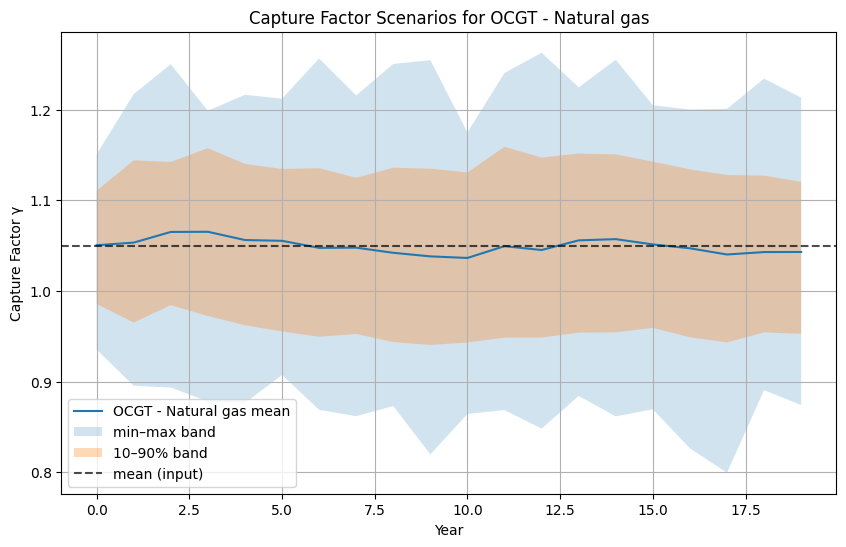

In [34]:
for t in time_periods:
    for b in blocks:
        for s in scenarios:  # first 5 scenarios
            c = model.getConstrByName(f"BlockCap_{t}_{b}_s{s}")
            if abs(c.Slack) < 1e-6:
                print(f"Binding: t={t}, b={b}, s={s}")

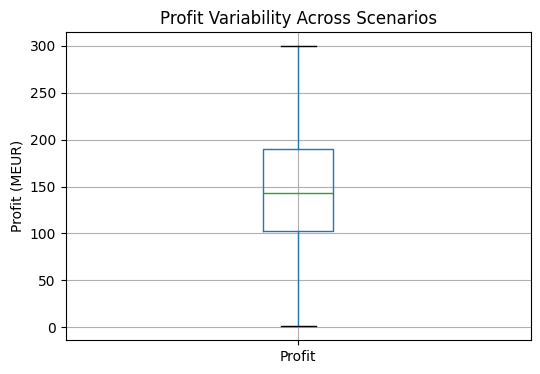

In [30]:
df_profit.boxplot(figsize=(6,4))
plt.title("Profit Variability Across Scenarios")
plt.ylabel("Profit (MEUR)")
plt.grid(True)
plt.show()


In [17]:
final_capacity = pd.Series({
    tech: capacity[tech, num_periods-1].X
    for tech in tech_names
}, name="Final Capacity (MW)")

display(final_capacity.sort_values(ascending=False))



OCGT - Natural gas       381.4
Onshore wind             381.4
Utility-scale PV         381.4
Diesel engine farm         0.0
Coal power plant           0.0
Nuclear power plant        0.0
Offshore wind (fixed)      0.0
Name: Final Capacity (MW), dtype: float64

In [18]:
energy_df = pd.DataFrame({
    (tech, s): sum(energy[tech, t, s].X for t in time_periods) / 1e3  # Convert to GWh
    for tech in tech_names
    for s in scenarios
}).T

energy_df.index = pd.MultiIndex.from_tuples(energy_df.index, names=['Technology', 'Scenario'])

display(energy_df)


ValueError: If using all scalar values, you must pass an index

In [64]:
if model.status != GRB.OPTIMAL:
    print(f"Model did not solve to optimality. Status: {model.status}")

else:
    print("Optimal solution found.\n")

    budget_df = pd.DataFrame({
        t: [budget[t].X]
        for t in time_periods
    }, index=["Budget (MEUR)"])

    print("---- Budget Evolution (MEUR) ----")
    display(budget_df)
    print()

    rev_cost_df = pd.DataFrame({
        t: {
            "Revenue (MEUR)":     revenue[t].X,
            "Var OPEX (MEUR)":    op_cost[t].X,
            "Fixed OPEX (MEUR)":  fixed_om_cost[t].X,
            "CAPEX (MEUR)":       capex_cost[t].X,
            "Net Cash Flow":      revenue[t].X - op_cost[t].X - capex_cost[t].X - fixed_om_cost[t].X
        }
        for t in time_periods
    })

    print("---- Revenue & Costs per Period (MEUR) ----")
    display(rev_cost_df)
    print()

    capacity_df = pd.DataFrame({
        t: {tech: capacity[tech, t].X for tech in tech_names}
        for t in time_periods
    })

    capacity_df.index.name = "Technology"

    capacity_df.loc["Total"] = capacity_df.sum(axis=0)

    print("---- Installed Capacity (MW) ----")
    display(capacity_df)
    print()

    production_df = pd.DataFrame({
        t: {tech: energy[tech, t].X/1e3 for tech in tech_names}
        for t in time_periods
    })

    production_df.index.name = "Technology"
    production_df.loc["Total"] = production_df.sum(axis=0)

    print("---- Energy Production (GWh) ----")
    display(production_df)
    print()

    totals_df = pd.DataFrame({
        "Total Revenue":      [sum(revenue[t].X for t in time_periods)],
        "Total Variable OPEX":[sum(op_cost[t].X for t in time_periods)],
        "Total Fixed OPEX":   [sum(fixed_om_cost[t].X for t in time_periods)],
        "Total CAPEX":        [sum(capex_cost[t].X for t in time_periods)],
        "Final Budget":       [budget[num_periods-1].X]
    })

    print("---- TOTALS OVER ALL PERIODS ----")
    display(totals_df)

Optimal solution found.

---- Budget Evolution (MEUR) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Budget (MEUR),50.0,15.204048,17.258143,18.778015,21.686655,24.36705,27.859326,29.665616,29.284664,30.634065,32.422499,31.754775,63.817231,96.299403,129.330206,163.055655,197.63909,233.261412,270.121335,308.258925



---- Revenue & Costs per Period (MEUR) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Revenue (MEUR),24.122352,26.931524,29.257825,33.010891,36.608428,41.084856,43.962605,44.589784,46.738484,49.345767,49.522806,50.205464,51.000155,51.923762,52.993383,54.226345,55.640208,57.252784,58.905427,60.778310
Var OPEX (MEUR),1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276,1.814276
Fixed OPEX (MEUR),0.879433,1.259534,1.690988,2.160438,2.702604,3.311781,4.008264,4.641420,5.065742,5.509617,5.979405,5.979405,5.979405,5.979405,5.979405,5.979405,5.979405,5.979405,5.979405,5.979405
CAPEX (MEUR),50.000000,15.204048,17.258143,18.778015,21.686655,24.367050,27.859326,29.665616,29.284664,30.634065,32.422499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Net Cash Flow,-28.571357,8.653667,8.494418,10.258162,10.404893,11.591749,10.280739,8.468472,10.573802,11.387810,9.306627,42.411783,43.206474,44.130081,45.199703,46.432664,47.846527,49.459103,51.111746,52.984629



---- Installed Capacity (MW) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Technology,,,,,,,,,,,,,,,,,,,,
Diesel engine farm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OCGT - Natural gas,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082,105.458082
Coal power plant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Nuclear power plant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Onshore wind,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.975266,34.440191,61.078508,89.271986,89.271986,89.271986,89.271986,89.271986,89.271986,89.271986,89.271986,89.271986,89.271986
Offshore wind (fixed),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Utility-scale PV,1.143951,41.154603,86.570770,135.986599,193.056744,257.180561,330.494576,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000,381.400000
Total,106.602033,146.612685,192.028851,241.444681,298.514826,362.638643,435.952658,495.833348,521.298273,547.936590,576.130068,576.130068,576.130068,576.130068,576.130068,576.130068,576.130068,576.130068,576.130068,576.130068



---- Energy Production (GWh) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Technology,,,,,,,,,,,,,,,,,,,,
Diesel engine farm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OCGT - Natural gas,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247,378.763247
Coal power plant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Nuclear power plant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Onshore wind,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.235564,123.695388,219.369570,320.629264,320.629264,320.629264,320.629264,320.629264,320.629264,320.629264,320.629264,320.629264,320.629264
Offshore wind (fixed),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Utility-scale PV,1.603362,57.682291,121.337591,190.598817,270.588333,360.464274,463.221198,534.570240,534.570240,534.570240,534.570240,534.570240,534.570240,534.570240,534.570240,534.570240,534.570240,534.570240,534.570240,534.570240
Total,380.366609,436.445539,500.100838,569.362064,649.351580,739.227521,841.984445,945.569051,1037.028876,1132.703057,1233.962751,1233.962751,1233.962751,1233.962751,1233.962751,1233.962751,1233.962751,1233.962751,1233.962751,1233.962751



---- TOTALS OVER ALL PERIODS ----


,Total Revenue,Total Variable OPEX,Total Fixed OPEX,Total CAPEX,Final Budget
0,918.10116,36.285519,91.023866,297.160082,308.258925


In [40]:
if model.status != GRB.OPTIMAL:
    print(f"Model did not solve to optimality. Status: {model.status}")

else:
    print("\n🎯 Robust Optimal Solution Found\n")

    # Worst-case profit (objective value in robust model)
    print(f"📉 Worst-Case Profit (Model Objective): {model.objVal:.2f} MEUR")

    # Compare profit across scenarios
    print("\n📊 Profit per Scenario (MEUR):")
    for s in scenarios:
        profit_s = sum(
            revenue[t, s].X 
            - op_cost[t, s].X 
            - co2_cost[t, s].X
            - fixed_om_cost[t].X
            - capex_cost[t].X
            for t in time_periods
        )
        print(f"  Scenario {s}: {profit_s:.2f} MEUR")

    print("\n🏭 Final Installed Capacity (MW):")
    for tech in tech_names:
        print(f"  {tech}: {capacity[tech, num_periods-1].X:.1f} MW")

    print("\n💰 Final Budget by Scenario (MEUR):")
    for s in scenarios:
        print(f"  Scenario {s}: {budget[num_periods-1, s].X:.2f} MEUR")

    print("\n⚡ Total Energy Produced in Final Year (GWh):")
    for s in scenarios:
        energy_s = sum(energy[tech, num_periods-1, s].X for tech in tech_names) / 1e3
        print(f"  Scenario {s}: {energy_s:.2f} GWh")



🎯 Robust Optimal Solution Found

📉 Worst-Case Profit (Model Objective): 2184.27 MEUR

📊 Profit per Scenario (MEUR):
  Scenario 0: 1820.69 MEUR
  Scenario 1: 2320.10 MEUR
  Scenario 2: 2493.72 MEUR
  Scenario 3: 2114.78 MEUR
  Scenario 4: 2172.07 MEUR

🏭 Final Installed Capacity (MW):
  Diesel engine farm: 93.1 MW
  OCGT - Natural gas: 381.4 MW
  Coal power plant: 0.0 MW
  Nuclear power plant: 0.0 MW
  Onshore wind: 381.4 MW
  Offshore wind (fixed): 0.0 MW
  Utility-scale PV: 381.4 MW

💰 Final Budget by Scenario (MEUR):
  Scenario 0: 1706.57 MEUR
  Scenario 1: 2138.86 MEUR
  Scenario 2: 2348.61 MEUR
  Scenario 3: 1943.37 MEUR
  Scenario 4: 2036.94 MEUR

⚡ Total Energy Produced in Final Year (GWh):
  Scenario 0: 3274.24 GWh
  Scenario 1: 3559.75 GWh
  Scenario 2: 3559.75 GWh
  Scenario 3: 3559.75 GWh
  Scenario 4: 3559.75 GWh


#### Visualizations

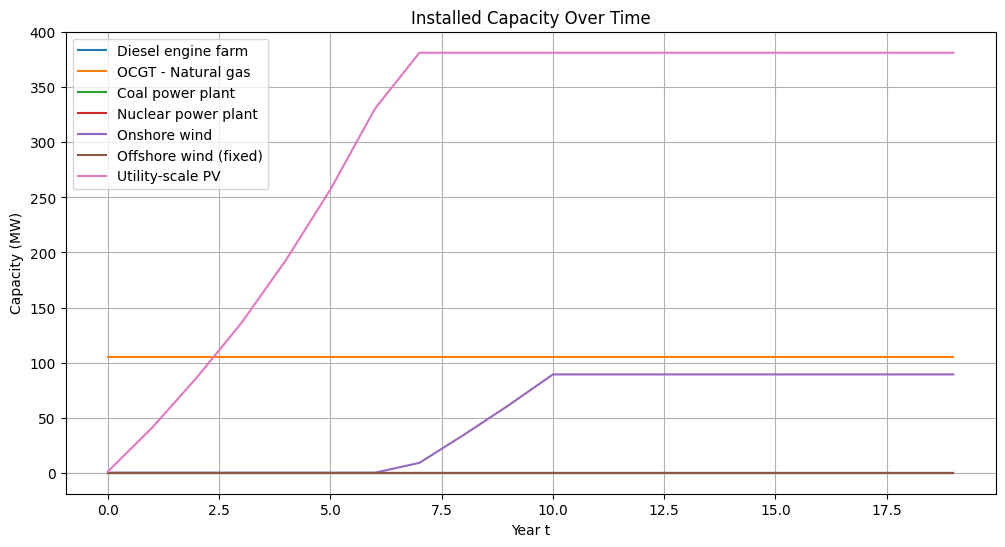

In [65]:
import matplotlib.pyplot as plt

# Build dataframe-like structure
cap_plot = {tech: [capacity[tech,t].X for t in time_periods] 
            for tech in tech_names}

plt.figure(figsize=(12,6))
for tech, vals in cap_plot.items():
    plt.plot(time_periods, vals, label=tech)

plt.title("Installed Capacity Over Time")
plt.xlabel("Year t")
plt.ylabel("Capacity (MW)")
plt.legend()
plt.grid(True)
plt.show()

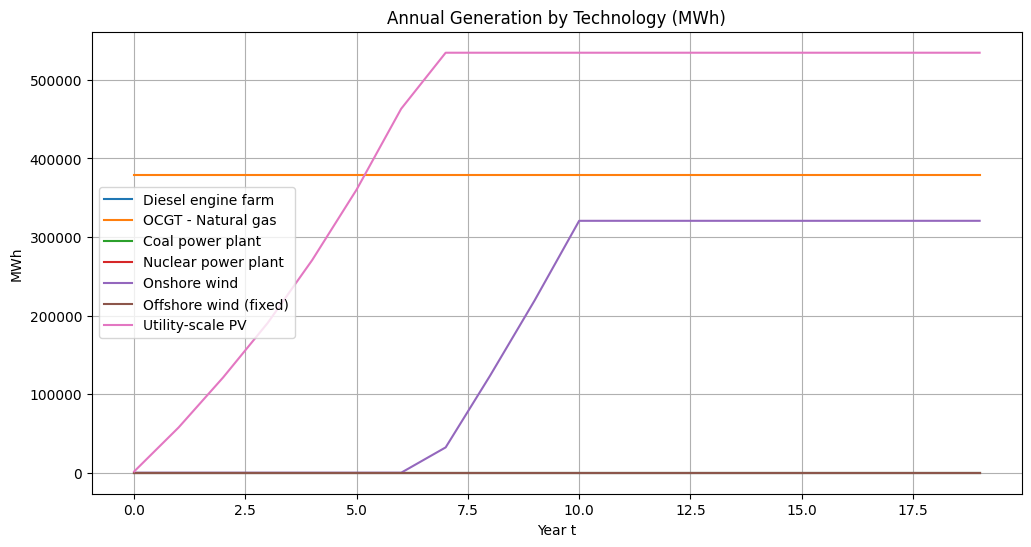

In [66]:
gen_plot = {tech: [energy[tech,t].X for t in time_periods]
            for tech in tech_names}

plt.figure(figsize=(12,6))
for tech, vals in gen_plot.items():
    plt.plot(time_periods, vals, label=tech)

plt.title("Annual Generation by Technology (MWh)")
plt.xlabel("Year t")
plt.ylabel("MWh")
plt.legend()
plt.grid(True)
plt.show()

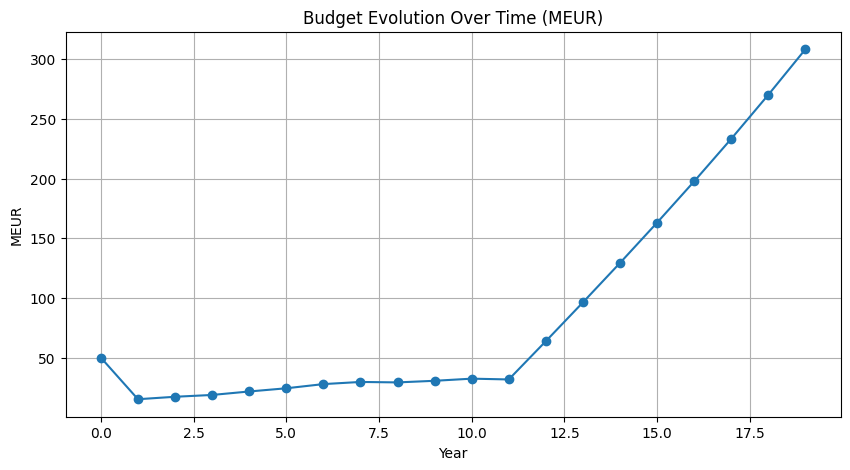

In [67]:
bud = [budget[t].X for t in time_periods]

plt.figure(figsize=(10,5))
plt.plot(time_periods, bud, marker="o")
plt.title("Budget Evolution Over Time (MEUR)")
plt.xlabel("Year")
plt.ylabel("MEUR")
plt.grid(True)
plt.show()

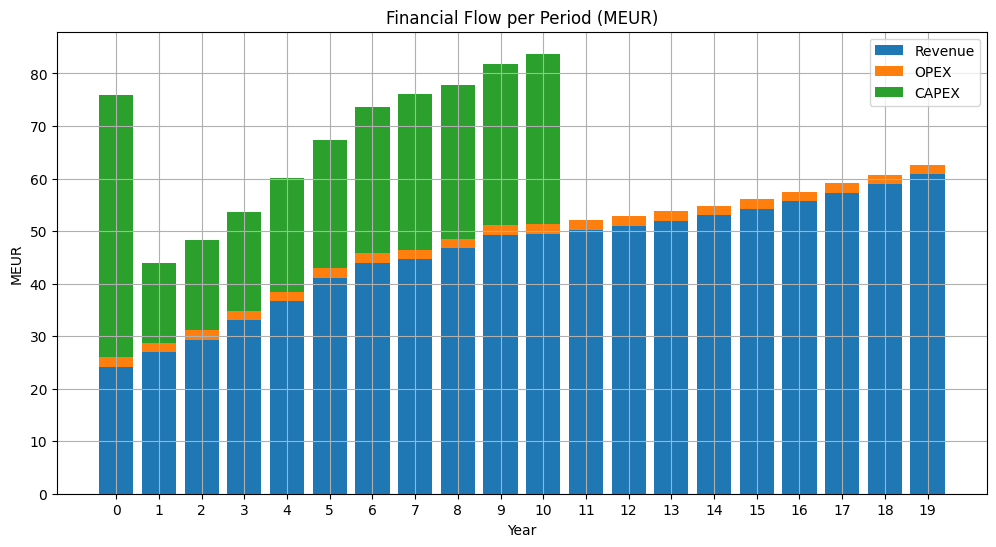

In [68]:
import numpy as np

rev = [revenue[t].X for t in time_periods]
op  = [op_cost[t].X for t in time_periods]
cap = [capex_cost[t].X for t in time_periods]

x = np.arange(len(time_periods))

plt.figure(figsize=(12,6))
plt.bar(x, rev, label="Revenue")
plt.bar(x, op, bottom=rev, label="OPEX")
plt.bar(x, cap, bottom=np.array(rev)+np.array(op), label="CAPEX")

plt.xticks(x, time_periods)
plt.title("Financial Flow per Period (MEUR)")
plt.xlabel("Year")
plt.ylabel("MEUR")
plt.legend()
plt.grid(True)
plt.show()

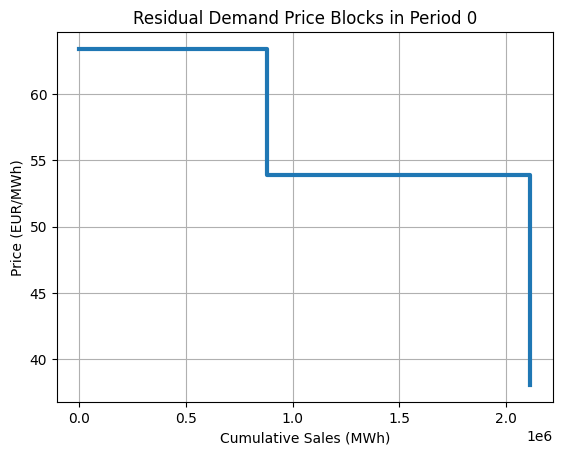

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

t = 0  # choose period to visualize (e.g., first year)

block_volumes = [Q_block[(t, b)] for b in blocks]
s = 0  # choose any scenario for visualization
block_prices  = [pi_block[(s, t, b)] * 1e6 for b in blocks]

# Build stepwise curve
x_vals = [0]
y_vals = []

for b in blocks:
    x_vals.append(x_vals[-1] + block_volumes[b-1])
    y_vals.append(block_prices[b-1])

plt.step(x_vals[:-1], y_vals, where='post', linewidth=3)
plt.xlabel("Cumulative Sales (MWh)")
plt.ylabel("Price (EUR/MWh)")
plt.title(f"Residual Demand Price Blocks in Period {t}")
plt.grid(True)
plt.show()

In [ ]:
sales_df = pd.DataFrame({
    f"Block {b}": [
        sum(sales[tech, t, b, 0].X for tech in tech_names)
        for t in time_periods
    ]
    for b in blocks
})

sales_df["Total Sales"] = sales_df.sum(axis=1)
sales_df.index = [f"Period {t}" for t in time_periods]
sales_df

,Block 1,Block 2,Block 3,Total Sales
Period 0,3.803666e+05,0.000000,0.0,3.803666e+05
Period 1,4.364455e+05,0.000000,0.0,4.364455e+05
Period 2,5.001008e+05,0.000000,0.0,5.001008e+05
Period 3,5.693621e+05,0.000000,0.0,5.693621e+05
Period 4,6.493516e+05,0.000000,0.0,6.493516e+05
Period 5,7.392275e+05,0.000000,0.0,7.392275e+05
Period 6,8.419844e+05,0.000000,0.0,8.419844e+05
Period 7,9.455691e+05,0.000000,0.0,9.455691e+05
Period 8,1.032525e+06,4504.046046,0.0,1.037029e+06
Period 9,1.053175e+06,79527.731045,0.0,1.132703e+06


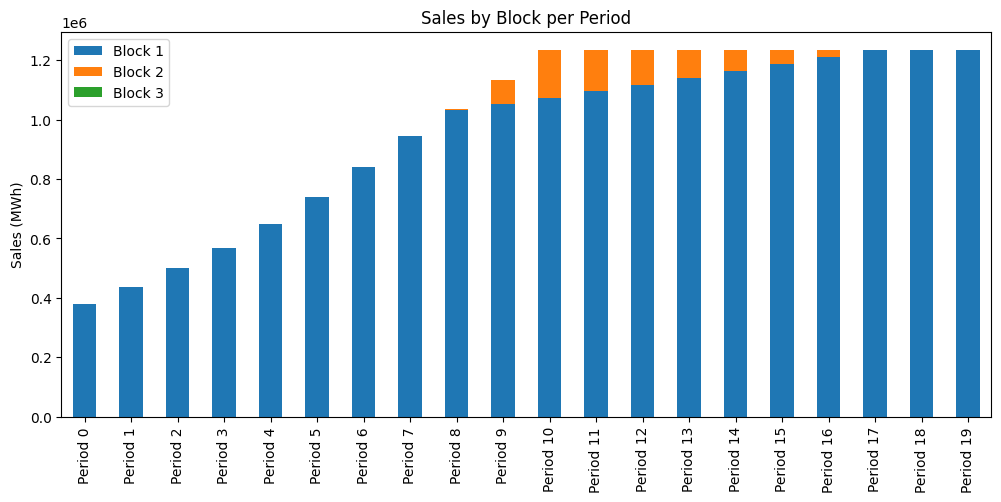

In [71]:
sales_df[["Block 1", "Block 2", "Block 3"]].plot(kind="bar", stacked=True, figsize=(12,5))
plt.ylabel("Sales (MWh)")
plt.title("Sales by Block per Period")
plt.show()

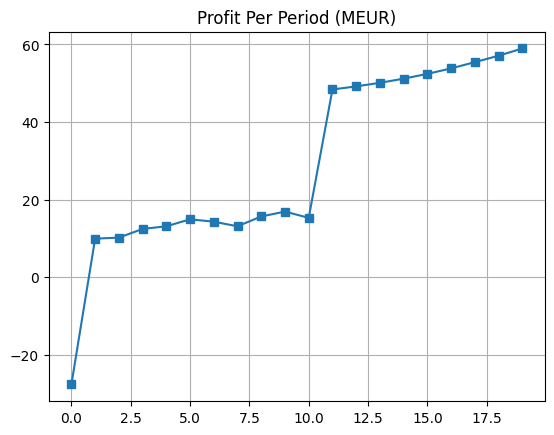

In [72]:
profit_t = [revenue[t].X - op_cost[t].X - capex_cost[t].X 
            for t in time_periods]

plt.plot(time_periods, profit_t, marker="s")
plt.title("Profit Per Period (MEUR)")
plt.grid(True)
plt.show()

#### Model Duals

In [73]:
for t in time_periods:
    constr = model.getConstrByName(f"DemandCap_{t}")
    print(f"Dual Demand Cap t={t}: {constr.Pi:.4f}")

AttributeError: 'NoneType' object has no attribute 'Pi'

In [ ]:
for tech in tech_names:
    for t in time_periods:
        c = model.getConstrByName(f"MaxCapacity_{tech}_{t}")
        if c is not None and abs(c.Pi) > 1e-6:
            print(f"{tech}, t={t}: shadow price = {c.Pi}")

In [ ]:
for t in time_periods:
    c = model.getConstrByName(f"InvLimit_{t}")   # capex_cost[t] <= budget[t]
    print(f"Shadow price investment limit t{t}: {c.Pi:.4f}")

Shadow price investment limit t0: 8.4407
Shadow price investment limit t1: 4.8919
Shadow price investment limit t2: 2.6760
Shadow price investment limit t3: 1.6783
Shadow price investment limit t4: 0.8610
Shadow price investment limit t5: 0.4283
Shadow price investment limit t6: 0.2820
Shadow price investment limit t7: 0.2118
Shadow price investment limit t8: 0.1164
Shadow price investment limit t9: 0.0000
Shadow price investment limit t10: 0.0000
Shadow price investment limit t11: 0.0000
Shadow price investment limit t12: 0.0000
Shadow price investment limit t13: 0.0000
Shadow price investment limit t14: 0.0000
Shadow price investment limit t15: 0.0000
Shadow price investment limit t16: 0.0000
Shadow price investment limit t17: 0.0000
Shadow price investment limit t18: 0.0000
Shadow price investment limit t19: 0.0000


In [ ]:
for t in time_periods[:-1]:
    c = model.getConstrByName(f"BudgetDyn_{t}")
    print(f"Shadow on budget recursion t={t}: {c.Pi:.4f}")

Shadow on budget recursion t=0: 11.1458
Shadow on budget recursion t=1: 6.2539
Shadow on budget recursion t=2: 3.5779
Shadow on budget recursion t=3: 1.8996
Shadow on budget recursion t=4: 1.0385
Shadow on budget recursion t=5: 0.6102
Shadow on budget recursion t=6: 0.3283
Shadow on budget recursion t=7: 0.1164
Shadow on budget recursion t=8: -0.0000
Shadow on budget recursion t=9: -0.0000
Shadow on budget recursion t=10: -0.0000
Shadow on budget recursion t=11: -0.0000
Shadow on budget recursion t=12: -0.0000
Shadow on budget recursion t=13: -0.0000
Shadow on budget recursion t=14: -0.0000
Shadow on budget recursion t=15: -0.0000
Shadow on budget recursion t=16: -0.0000
Shadow on budget recursion t=17: -0.0000
Shadow on budget recursion t=18: -0.0000
